In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import tensorflow as tf
import seaborn as sns

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

In [4]:
RANDOM_SEED = 42
numpy.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
df = pd.read_csv("Hotel_Reviews.csv",parse_dates = ['Review_Date'],nrows = 20000)
df.shape

(20000, 17)

In [7]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [8]:
df["review"] = df["Negative_Review"] + df["Positive_Review"]
df["review_type"] = df["Reviewer_Score"].apply(lambda x: "negative" if x<7 else "positive")

In [10]:
df = df[["review","review_type"]]

In [11]:
df.review_type.value_counts()

positive    16398
negative     3602
Name: review_type, dtype: int64

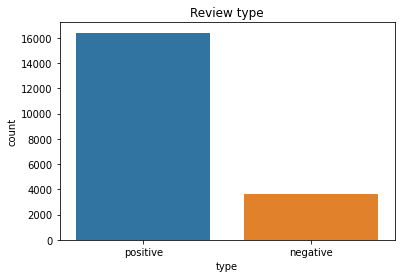

In [12]:
sns.countplot(
  x='review_type',
  data = df,
  order= df.review_type.value_counts().index
)
plt.xlabel("type")
plt.title("Review type");

In [13]:
good_reviews = df[df.review_type == "positive"]
bad_reviews = df[df.review_type == "negative"]

In [14]:
good_df = good_reviews.sample(n = len(bad_reviews), random_state = RANDOM_SEED)
bad_df = bad_reviews

In [16]:
review_df = good_df.append(bad_df).reset_index(drop=True)
review_df.shape

C:\Users\Pratik\AppData\Local\Temp/ipykernel_8396/2376158853.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  review_df = good_df.append(bad_df).reset_index(drop=True)


(7204, 2)

In [17]:
review_df.head()

,review,review_type
0,the bath shower looked a bit tired and the ro...,positive
1,Booked a classic double room but it turned ou...,positive
2,21 00 each for cooked breakfast is a bit expe...,positive
3,No Negative Staff were so friendly Room was im...,positive
4,Too small We had a junior suite But it was so...,positive


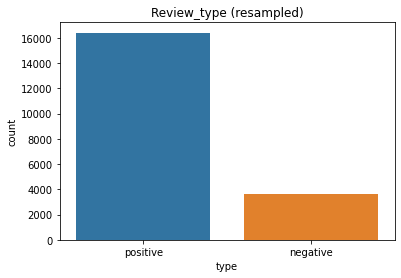

In [21]:
sns.countplot(
  x='review_type',
  data = df,
  order= df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review_type (resampled)");

In [22]:
review_df["review_type"].value_counts()

positive    3602
negative    3602
Name: review_type, dtype: int64

In [23]:
sentiment_label = review_df.review_type.factorize()
sentiment_label

(array([0, 0, 0, ..., 1, 1, 1], dtype=int64),
 Index(['positive', 'negative'], dtype='object'))

In [24]:
review = review_df.review.values
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(review)
vocab_size  = len(tokenizer.word_index)+1
encoded_docs = tokenizer.texts_to_sequences(review)
padded_sequences = pad_sequences(encoded_docs, maxlen = 200)

In [25]:
print(review[2])
print(encoded_docs[2])

 21 00 each for cooked breakfast is a bit expensive  Staff were all excellent lovely hotel and a great location for our visit 
[3416, 540, 439, 11, 643, 23, 20, 5, 110, 148, 14, 19, 48, 67, 81, 16, 2, 5, 39, 18, 11, 44, 440]


In [26]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_length,input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50,dropout=0.5,recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           325760    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 342,411
Trainable params: 342,411
Non-trainable params: 0
__________________________________________________

In [27]:
history = model.fit(padded_sequences,sentiment_label[0],validation_split=0.2,epochs=5,batch_size=32)

Epoch 1/5
181/181 [==============================] - 50s 245ms/step - loss: 0.5872 - accuracy: 0.6880 - val_loss: 0.8812 - val_accuracy: 0.4455
Epoch 2/5
181/181 [==============================] - 43s 238ms/step - loss: 0.3979 - accuracy: 0.8225 - val_loss: 0.6753 - val_accuracy: 0.6641
Epoch 3/5
181/181 [==============================] - 43s 239ms/step - loss: 0.3316 - accuracy: 0.8553 - val_loss: 0.7313 - val_accuracy: 0.6350
Epoch 4/5
181/181 [==============================] - 44s 243ms/step - loss: 0.3011 - accuracy: 0.8702 - val_loss: 1.0098 - val_accuracy: 0.6037
Epoch 5/5
181/181 [==============================] - 43s 238ms/step - loss: 0.2894 - accuracy: 0.8791 - val_loss: 0.6709 - val_accuracy: 0.6537


In [28]:
def predict_sentiment(text):
    tw=tokenizer.texts_to_sequences([text])
    tw=pad_sequences(tw,maxlen=200)
    prediction=int(model.predict(tw).round().item())
    print("Prediction label:",sentiment_label[1][prediction])

In [30]:
test_sentence1 = "this project is good"
predict_sentiment(test_sentence1)

test_sentence2 = "this project is worst"
predict_sentiment(test_sentence2)

1/1 [==============================] - 0s 49ms/step
Prediction label: positive
1/1 [==============================] - 0s 43ms/step
Prediction label: negative
